In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
plt.style.use('fivethirtyeight')

# Statistical Significance in Data

How many measurements do you need to _prove_ two measurements are different?

This is a problem of constant debate with many different approaches, 
- [Student t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)
- [Analysis of Variance (ANOVA)](https://en.wikipedia.org/wiki/Analysis_of_variance)
- [Analysis of Covariance (ANCOVA)](https://en.wikipedia.org/wiki/Analysis_of_covariance)
- [Permutation test](https://en.wikipedia.org/wiki/Permutation_test)
- [Bootstrapping test](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))
- [Wilcoxon test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)

In all of these approaches, scientists and engineers create a quantitative test to accept or reject the hypothesis that two set of data are _not_ significantly different. This concept was _very_ strange to me at first. How can two different measurements be considered the same? It wasn't until I started practicing, building, and applying engineering concepts that this question started to make sense. 

## Generate some data we _know_ is different

Monte Carlo experiments are a great way to start understanding this difficult question, lets build x2 100-value data sets. Consider a case where two people, Pat and Jim, are going to throw the same size ball as far as possible. We know Pat is stronger than Jim. Pat creates an average of 68 J of work throwing a ball, and Jim creates an average of 65 J. 

Pat is _on average_ $\frac{68 - 65}{65} = \frac{3}{65} = 4.6\%$ stronger than Jim. Let's assume both Pat and Jim can sometimes throw a little faster and sometimes a little slower so the actual values are $68\pm 3~J$ and $65\pm 2~J$. Now, we have a statistical comparison

- normal distribution at $68 \pm 3~J$
- normal distribution at $65 \pm 2~J$

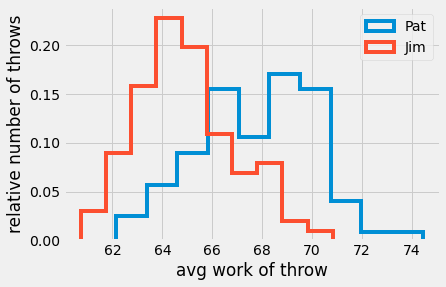

In [2]:
rng = default_rng(42)

Pat = rng.normal(loc = 68, scale = 3, size = 100)
Jim = rng.normal(loc = 65, scale = 2, size = 100)

plt.hist(Pat,
        histtype='step',
        linewidth = 4,
         label = 'Pat',
         density = True,)
        #bins = np.linspace(50,80, 31))
plt.hist(Jim, 
        histtype = 'step',
        linewidth = 4,
         label = 'Jim',
         density = True,)
        #bins =np.linspace(50, 80, 41))
plt.xlabel('avg work of throw')
plt.ylabel('relative number of throws')
plt.legend();

In [3]:
print('set01 = {:1.2f} +/- {:1.2f}'.format(np.mean(Pat), np.std(Pat)))
print('set02 = {:1.2f} +/- {:1.2f}'.format(np.mean(Jim), np.std(Jim)))

set01 = 67.85 +/- 2.32
set02 = 64.98 +/- 1.95


# Are these measurements different?

The two histograms are different, but many of the values throws between Pat and Jim are the same. For example, both throwers had work of 66 J 10-15% of the throws. If we only consider the reported means, 67.9 and 65, there is a significant difference between the two results, but how accurate is this value of mean?

Lets calculate more data sets and see how much the much the mean can change. 

Text(0.5, 1.0, 'range of means using x50 sets of 100 data points')

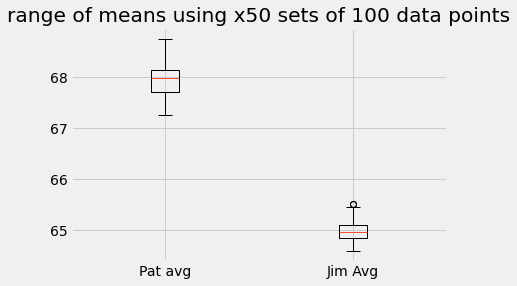

In [4]:
set_01 = rng.normal(loc = 68, scale = 3, size = (50,100))
set_02 = rng.normal(loc = 65, scale = 2, size = (50, 100))

mean_01 = np.mean(set_01, axis = 1)
mean_02 = np.mean(set_02, axis = 1)

plt.boxplot([mean_01, mean_02], labels=['Pat avg', 'Jim Avg'])
plt.title('range of means using x50 sets of 100 data points')

(array([4., 3., 9., 8., 9., 7., 2., 3., 2., 3.]),
 array([64.60260574, 64.69393174, 64.78525773, 64.87658373, 64.96790973,
        65.05923573, 65.15056173, 65.24188772, 65.33321372, 65.42453972,
        65.51586572]),
 [<matplotlib.patches.Polygon at 0x76930857bdf0>])

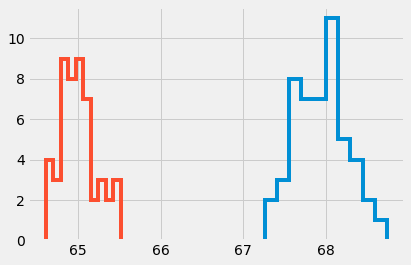

In [5]:
plt.hist(mean_01,
        histtype='step',
        linewidth = 4,)
        #bins = np.linspace(-0.5,1.5, 31))
plt.hist(mean_02, 
        histtype = 'step',
        linewidth = 4,)
        #bins =np.linspace(-0.5, 1.5, 31))

In the first, `boxplot` we see that for all sets of 100 throws Pat's average work is higher than Jim's average work. In the second histogram, we see the same information as the boxplot, but also the number of times the average was measured over the 50 trial sets. For example, the most likely average for Jim happened 9 times out of 50 at 65 J while Pat's average happened 12 times just over 68 J. 

## T-test and the _p-value_ for reporting significance

This process is the same idea that William Gossett proposed in the formulation of the Student t-test. Rather than trying to prove that the two data sets are different, he built a test to see if the 2 means of the data sets were different _assuming the mean is calculated from randomly sampled normally distributed data sets_.  

The [T-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) is now a standard way for scientists and engineers to discuss "how likely it is that any observed difference between groups is due to chance. Being a probability, P can take any value between 0 and 1" [What does the P-value mean? Dahiru and Dip 2008](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4111019/). Let's look at the p-value for 5 of the 50 data sets we made

In [6]:
from scipy.stats import ttest_ind

In [7]:
for i in range(0, 50, 10):
    print(ttest_ind(set_01[i, :], set_02[i,:]))

Ttest_indResult(statistic=7.312243316550984, pvalue=6.360006381352651e-12)
Ttest_indResult(statistic=7.287116791592945, pvalue=7.367998889788595e-12)
Ttest_indResult(statistic=8.310616638454743, pvalue=1.4971760525056898e-14)
Ttest_indResult(statistic=9.126645222590843, pvalue=8.222918423055652e-17)
Ttest_indResult(statistic=10.319980173376365, pvalue=2.962493630514987e-20)


In all 5 data sets, the p-value is much less than 1%. The largest is 7.4e-12%. With 100 data points, and a standard deviation of equal to the difference between the means, we can be almost certain that the difference in the means is _not_ by chance. Thus we reject this null hypothesis. 

## When is the p-value < 0.05?

Now, lets decrease the number of times we measure Pat and Jim's throwing work. We will only create 5 measurements of work from the normal distributions, but do the same experiment 50 times again. 

Text(0.5, 1.0, 'range of means using x50 sets of 5 data points\nlocated at 0 and 1')

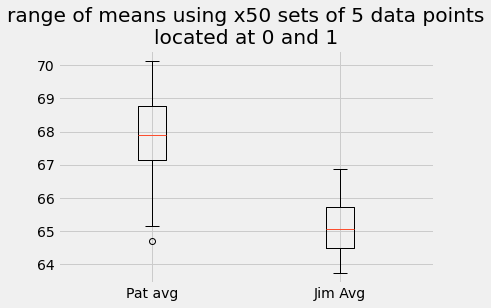

In [8]:
set_01 = rng.normal(loc = 68, scale = 3, size = (50,5))
set_02 = rng.normal(loc = 65, scale = 2, size = (50, 5))

mean_01 = np.mean(set_01, axis = 1)
mean_02 = np.mean(set_02, axis = 1)

plt.boxplot([mean_01, mean_02], labels=['Pat avg', 'Jim Avg'])
plt.title('range of means using x50 sets of 5 data points\nlocated at 0 and 1')

The _population_ means are still where we expect them, at 68 and 65, but each set has a _sample_ mean that varies from 65 to 71 and 63 to 67 for the $\times 5$ data points.



In [9]:
for i in range(0, 50, 10):
    print(ttest_ind(set_01[i, :], set_02[i,:]))

Ttest_indResult(statistic=1.152311308480031, pvalue=0.2824615713987898)
Ttest_indResult(statistic=2.980630022687666, pvalue=0.017583498894211742)
Ttest_indResult(statistic=1.72106628291478, pvalue=0.12354561386016896)
Ttest_indResult(statistic=-0.1759509471479072, pvalue=0.8647047810857478)
Ttest_indResult(statistic=0.475004458003587, pvalue=0.6474812142027769)


In the case of using 5 randomly sampled values from the normal distributions, the chance that the means are equal is as high as 40% and as low as 1.7%. This means we cannot claim the results are _statistically significant_ even though we _know_ that Pat's `set_01` has a mean of 68 J and Jim's `set_02` has a mean of 65 J. 



## Throwing distance

In [16]:
Pat_W = rng.normal(loc = 68, scale = 3, size = (50,))
Jim_W = rng.normal(loc = 65, scale = 2, size = (50,))

Pat_angle = rng.normal(loc = np.pi/4, scale = 5/180*np.pi, size = (50,))
Jim_angle = rng.normal(loc = np.pi/4, scale = 5/180*np.pi, size = (50,))

Pat_v = np.sqrt(2*Pat_W/0.15)
Jim_v = np.sqrt(2*Jim_W/0.15)

Pat_tmax = Pat_v*np.sin(Pat_angle)

In [17]:
np.roots([-9.81/2*np.ones(50), np.sqrt(2*Pat_W/0.15)*np.sin(Pat_angle), 1])

/home/ryan/.conda/envs/work/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Signature: np.roots(p)
Docstring:
Return the roots of a polynomial with coefficients given in p.

The values in the rank-1 array `p` are coefficients of a polynomial.
If the length of `p` is n+1 then the polynomial is described by::

  p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]

Parameters
----------
p : array_like
    Rank-1 array of polynomial coefficients.

Returns
-------
out : ndarray
    An array containing the roots of the polynomial.

Raises
------
ValueError
    When `p` cannot be converted to a rank-1 array.

See also
--------
poly : Find the coefficients of a polynomial with a given sequence
       of roots.
polyval : Compute polynomial values.
polyfit : Least squares polynomial fit.
poly1d : A one-dimensional polynomial class.

Notes
-----
The algorithm relies on computing the eigenvalues of the
companion matrix [1]_.

References
----------
.. [1] R. A. Horn & C. R. Johnson, *Matrix Analysis*.  Cambridge, UK:
    Cambridge University Press, 1999, pp. 146-7.

Exam